### Identifying missing values in tabular data

Transform the CSV file to pandas.DataFrame

In [54]:
import pandas as pd 
from io import StringIO

csv_data = "csv-file"

df = pd.read_csv(csv_data)
print(df)

         A     B     C    D
type1  1.0   2.0   3.0  4.0
type2  5.0   6.0   NaN  8.0
type3  9.0  10.0  11.0  NaN


##### Omit invalid data

##### Impute missing values

Mean, median, the most frequent value

In [55]:
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
df = imr.transform(df)

print(df)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11.  6.]]


/Users/xuelisun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


## Handle categorical data

Transform categories to number.
* Simply use python dictionary (if it were simple)
* Call LabelEncoder()

In [56]:
# explicitly import data

jersey_df = pd.DataFrame(
    [['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']]
)
jersey_df.columns = ['color', 'size', 'price', 'classlabel']
print(jersey_df)

   color size  price classlabel
0  green    M   10.1     class1
1    red    L   13.5     class2
2   blue   XL   15.3     class1


In [57]:
size_mapping = {
    'M': 1,
    'L': 2,
    'XL': 3
}
inv_size_mapping = {s: n for n, s in size_mapping.items()}

print(jersey_df['size'])
print()

jersey_df['size'] = jersey_df['size'].map(size_mapping)
print(jersey_df)
print()

jersey_df['size'] = jersey_df['size'].map(inv_size_mapping)
print(jersey_df)

jersey_df['size'] = jersey_df['size'].map(size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

   color  size  price classlabel
0  green     1   10.1     class1
1    red     2   13.5     class2
2   blue     3   15.3     class1

   color size  price classlabel
0  green    M   10.1     class1
1    red    L   13.5     class2
2   blue   XL   15.3     class1


In [58]:
# call enumerate rather than hard coding
class_mapping = {label: idx for idx, label in enumerate(jersey_df['classlabel'].unique())}
print(class_mapping)

jersey_df['classlabel'] = jersey_df['classlabel'].map(class_mapping)
print(jersey_df)

{'class1': 0, 'class2': 1}
   color  size  price  classlabel
0  green     1   10.1           0
1    red     2   13.5           1
2   blue     3   15.3           0


In [59]:
# one-hot encoding on nominal features
# nominal feature: feat. without numerical relation
# e.g. red cannot compare with green

from sklearn.preprocessing import LabelEncoder

X = jersey_df[['color', 'size', 'price']].values
print(X)

color_le = LabelEncoder()
color_le.fit_transform(jersey_df['color'].values)

# color_le is array([1, 2, 0]), which is too numerical
# thus we'd better use one-hot encoder

[['green' 1 10.1]
 ['red' 2 13.5]
 ['blue' 3 15.3]]


array([1, 2, 0])

In [60]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()    # column 0
ohe.fit_transform(jersey_df[['color']])

print(ohe.categories_)
print(ohe.get_feature_names_out())

[array(['blue', 'green', 'red'], dtype=object)]
['color_blue' 'color_green' 'color_red']


In [61]:
pd.get_dummies(jersey_df[['price', 'color', 'size']],
               drop_first=True)
# drop_first maintains that the matrix is still of full rank

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


### Partition a dataset into separate training and test sets

In [62]:
df_wine = pd.read_csv("./wine/wine.data", header=None)

df_wine.columns = ['Class label', 'Alcohol', 
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnisium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/)D315 of diluted wines',
                   'Proline']

# familiar way: train_test_split
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:], df_wine.iloc[:, 0]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

### Bring to scale: Normalization and Standardization

* Normalization: scale to [0,1]
* Standardization: scale based on mean and standard deviation

In [63]:
# manually implement
X_train_norm = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
from IPython.display import display
#display(X_train_norm)

X_train_std = (X_train - np.mean(X_train)) / np.std(X_train)
#display(X_train_std)

/Users/xuelisun/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [64]:
# call from sklearn package
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.fit_transform(X_test)

### Select meaningful features
* Introduce suitable penalty functions. 
    - L1: lambda * (sum of |w|)
    - L2: lambda * (sum of |w|**2)

In [65]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=1, solver='liblinear')
lr.fit(X_train_std, y_train)
print('Training accuracy: ', lr.score(X_train_std, y_train))
print('Testing accuracy: ', lr.score(X_test_std, y_test))

Training accuracy:  1.0
Testing accuracy:  1.0


In [66]:
print(lr.intercept_)    # 截距
print(lr.coef_)

[-1.26352265 -1.21569645 -2.37028507]
[[ 1.24581293  0.18052504  0.74471044 -1.16242115  0.          0.
   1.16580052  0.          0.          0.          0.          0.55124063
   2.50984176]
 [-1.53948343 -0.38542429 -0.9956672   0.3637683  -0.058817    0.
   0.66675154  0.          0.         -1.93192695  1.23773283  0.
  -2.23248424]
 [ 0.13559212  0.16851783  0.35712358  0.          0.          0.
  -2.43794514  0.          0.          1.56376023 -0.81876899 -0.49234853
   0.        ]]


In [67]:
# # smaller the C, larger the lambda --> smaller w

# # following is written by github copilot
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression
# from sklearn.datasets import make_classification
# from sklearn.preprocessing import StandardScaler

# # Generate a synthetic dataset
# X, y = make_classification(n_samples=100, n_features=10, random_state=42)
# scaler = StandardScaler()
# X_train_std = scaler.fit_transform(X)

# # Define a range of C values
# C_values = np.logspace(-4, 4, 10)

# weights = []

# # Fit a logistic regression model for each value of C
# for C in C_values:
#     lr = LogisticRegression(penalty='l1', C=C, solver='liblinear')
#     lr.fit(X_train_std, y)
#     weights.append(lr.coef_[0])

# weights = np.array(weights)

# # Plot the weights
# plt.figure(figsize=(10, 6))
# for i in range(weights.shape[1]):
#     plt.plot(1/C_values, weights[:, i], label=f'Feature {i+1}')

# plt.xscale('log')
# plt.xlabel('1/C (log scale)')
# plt.ylabel('Weight coefficient')
# plt.title('Effect of regularization (1/C) on weight coefficients')
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.show()

### Sequential feature selection algorithm


In [76]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features,
                 scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring      # evaluate the performance of a model
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
                    train_test_split(X, y,
                                     test_size=self.test_size,
                                     random_state=1)
        dim = X_train.shape[1]  # numbers of initial features
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            # get combinations of (current dim-1) elements from indices_
            for p in combinations(self.indices_, r=dim-1):

                # calculate the score for subset p
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(score)
            self.indices_ = subsets[best]   # scale dimension down by 1
            self.subsets_.append(self.indices_) # subsets_ take record of current indices
            dim -= 1

            self.scores_.append(scores[best])   # record the best score of r features
        
        self.k_score_ = self.scores_[-1]    # the last score is the score of k_features

        return self

    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test,
                    indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

13


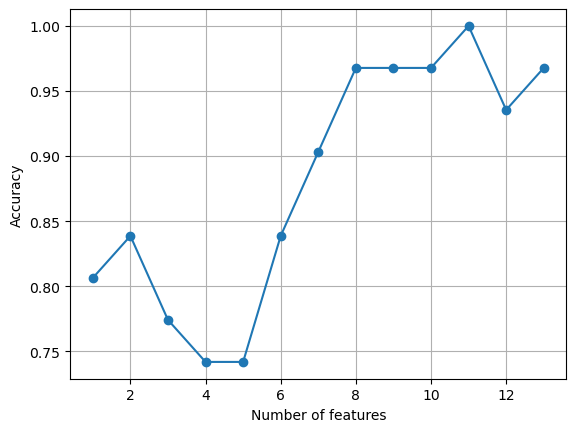

In [85]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]
# num of sbs.subsets_ = num of scaled features

print(len(k_feat))

plt.plot(k_feat, sbs.scores_, marker='o')
# plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [95]:
k2 = list(sbs.subsets_[11])
print(df_wine.columns[1:][k2])

Index(['Alcohol', 'Malic acid'], dtype='object')


 1)Proline                        0.185453
 2)Flavanoids                     0.174751
 3)Color intensity                0.143920
 4)OD280/)D315 of diluted wines   0.136162
 5)Alcohol                        0.118529
 6)Hue                            0.058739
 7)Total phenols                  0.050872
 8)Magnisium                      0.031357
 9)Malic acid                     0.025648
10)Proanthocyanins                0.025570
11)Alcalinity of ash              0.022366
12)Nonflavanoid phenols           0.013354
13)Ash                            0.013279


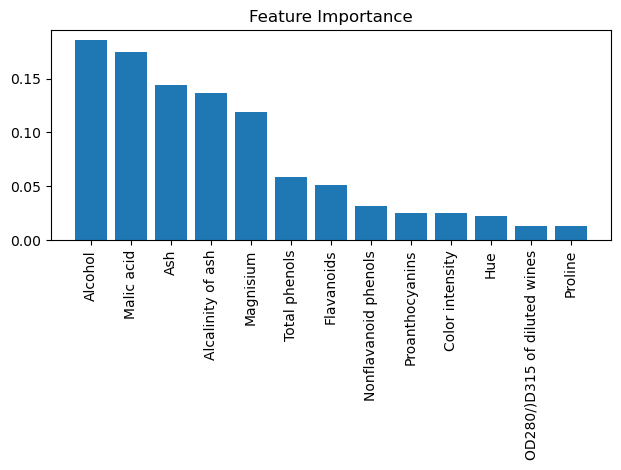

In [98]:
# Assessing feature importance with random forests

from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' % (f+1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]),
        feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()